# Explanation of a Nonlinear Resistor
author: Reza Mohammadi

email: mohamadi.reza@mail.um.ac.ir

# What Is a Resistor?


## Definition of a Resistor:
A resistor is an electrical component designed to limit the flow of current in a circuit. It is a passive two-terminal device, meaning it consumes energy but does not produce or store it.

### Resistive Materials:
Resistors are made from materials that resist the flow of electric current. These materials include:

Glass: A good insulator with high resistance.
Mica: Known for its high resistance and thermal stability, making it useful in specific applications.
Wood and Rubber: Typically considered insulating materials but can exhibit resistive properties in certain conditions.

#### Unit of Resistance:
Resistance is measured in ohms (Ω). One ohm is the resistance between two points of a conductor when a current of 1 ampere flows through it under a potential difference of 1 volt.


##### Applications of Resistors in Electronic Circuits:
Signal Level Adjustment: Used to control or reduce the current or voltage in a circuit.
Current Limiting: Preventing excessive current that could damage components.
Biasing Active Elements: Setting the operating conditions for active components such as transistors.
Termination of Transmission Lines: Avoiding signal reflection in transmission lines.
Voltage Division: Creating different voltage levels from a single fixed voltage source.

##### Importance in Circuit Design:

Resistors play a crucial role in the design of electronic circuits. They not only help in precise control of current and voltage but also protect components from damage caused by overcurrent or overvoltage. Furthermore, carefully designed resistor configurations can enhance the stability and performance of circuits.

![type of resistor](pic\Different-Types-of-Resistors-Updated-2.png)

# What is Non-linear resistor?

Non-linear resistors are resistors that exhibit a change in electric current based on variations in applied voltage or temperature,
rather than following Ohm's law. Unlike linear resistors,
where the current remains proportional to the voltage,
non-linear resistors have a more complex relationship between voltage and current.
This means that their resistance can vary significantly under different conditions.
There are various types of non-linear resistors, each serving specific applications in electronic circuits.
Some of the most commonly used non-linear resistors include thermistors,
which change resistance with temperature, and varistors, which adjust their resistance based on voltage changes.
These components are essential in protecting circuits, sensing temperature changes,
and in various other applications where variable resistance is required.

![type of resistor](pic\types_of_resistors.jpg)


# Varistor
A varistor, also known as a Voltage Dependent Resistor (VDR),
 is a type of resistor whose resistance changes with the applied voltage. 
When the voltage across the varistor increases, its resistance decreases, 
allowing more current to pass through. Conversely, as the voltage decreases, 
the resistance increases, limiting the current flow.
 This property makes varistors particularly useful for protecting circuits from voltage spikes and surges. 
They are commonly employed in applications such as surge protection devices and transient voltage suppression.
 By dynamically adjusting their resistance in response to voltage changes, 
varistors help maintain circuit integrity and prevent damage from excessive voltage.
 Overall, they play a crucial role in enhancing the reliability of electronic systems.



![varistor](pic\varistors.jpg)


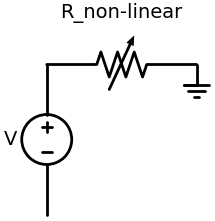

In [29]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += elm.SourceV().label('V')
    
    d += elm.ResistorVar().right().label('R_non-linear')
    
    d += elm.Ground()

    d.draw()


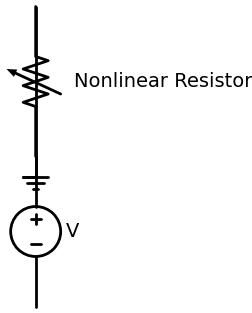

The current through the nonlinear resistor is approximately 1.08 A.


In [34]:
import schemdraw
import schemdraw.elements as elm
import numpy as np
from scipy.optimize import fsolve

with schemdraw.Drawing() as circuit:
    circuit += elm.SourceV().label('V', loc='bottom')  
    circuit += elm.ResistorVar().label('Nonlinear Resistor', loc='bottom')  
    circuit += elm.Line().down()  
    circuit += elm.Ground()


V = 12  
def resistance(I):
    
    return 10 + I**2


def equation(I):
    return V - I * resistance(I)


I_initial = 1.0


I_solution = fsolve(equation, I_initial)

print(f"The current through the nonlinear resistor is approximately {I_solution[0]:.2f} A.")


# code summary

1.A circuit consisting of a voltage source and a nonlinear resistor is drawn.

2.The resistor's value is determined using the function 𝑅=10+I^2

3.The circuit's current is calculated by solving the equation V - I.R(I) = 0

4.The calculated current value is displayed to the user.


# Thermistor
Thermal resistors, also known as thermistors, are components whose resistance changes with temperature.
 As the temperature rises, the resistance of a thermal resistor typically decreases,
 and when the temperature falls, the resistance increases.
 This property makes thermistors useful for measuring and controlling temperature in various applications.
 They are commonly employed in temperature sensors and control systems, 
where precise temperature monitoring is essential.
 Their sensitivity to temperature changes allows them to provide accurate feedback for regulating heating or cooling processes.

The main types of thermistors are NTC and PTC.
NTC is Negative Temperature Coefficient and in such devices, the resistance decreases as the temperature increases.
 These are used to protect the devices from over-voltage conditions.
PTC is Positive Temperature Coefficient and in such devices, the resistance increases as the temperature increases.
 These are used to protect the devices from over current conditions.
The following figure shows an NTC thermistor, along with its symbol.

![thermistor](pic\thermistor.jpg)


# Photo Resistor
Photoresistors, commonly known as Light Dependent Resistors (LDRs),
 are components whose resistance changes in response to light intensity. As the amount of light increases,
 the resistance of the LDR decreases, allowing more current to flow through. Conversely, when light intensity decreases,
 the resistance increases, restricting current flow. 
This unique property enables LDRs to be effectively used for measurement and control applications,
 such as in light sensors and automatic lighting systems.
 They play a crucial role in various electronic circuits, including those that require light detection and regulation.
 Overall, LDRs are essential for creating responsive systems that adjust based on ambient light conditions.



![photo resistor](pic\photo_resistor.jpg)


# Surface mount
These are being highly used since the introduction of surface mount technology.
 These can be termed as chip resistors, which means a resistive layer integrated on a ceramic chip.

These surface mount resistors are very small when compared to the normal resistors and hence occupy less space. 
They are effective and dissipate less heat. The invention of these resistors has changed the look of a PCB PrintedCircuitBoard
 and reduced its size greatly.

The advantages of surface mount resistors are −

These are compact in size.

These are very stable.

They have good tolerance.

They are effective in reducing heat dissipation.

The following figure shows the images of surface mount resistors.


![surface mount](pic\surface_mount.jpg)


# consolution

Non-linear resistors do not follow Ohm's law and exhibit varying behavior with changes in voltage or temperature.
 Types include thermistors, whose resistance changes with temperature, and varistors, which adjust resistance based on voltage. Thermistors are used for temperature measurement and control, while varistors protect circuits from voltage surges.
  Photoresistors (LDRs) change resistance with light intensity and are used in light sensors and automatic lighting systems. The advent of surface-mount technology (SMT) introduced compact chip resistors that save space and reduce heat dissipation, transforming PCB design. Thermistors are classified into NTC (resistance decreases with temperature) and PTC (resistance increases with temperature), used for over-voltage and over-current protection, respectively.

# sources

https://www.tutorialspoint.com/basic_electronics/basic_electronics_nonlinear_resistors.htm

https://byjus.com/physics/types-of-resistors/#:~:text=Non%2Dlinear%20resistors%20are%20those,commonly%20used%20are%20mentioned%20below.